# HPAP107 scRNA-seq and CODEX Integration (with cell type annotations)

Overview

This tutorial demonstrates how to integrate HPAP107 scRNA-seq and CODEX datasets from human pancreas using CelLink when cell-type annotations are available.

Outline
1. Data input
2. Data preprocessing
3. Cellink object construction and alignment
4. Feature imputation and cell-type matching
5. Visualization

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc

from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from sklearn.metrics.pairwise import cosine_similarity
import umap

import seaborn as sns

from cellink import Cellink

import requests
import os
import zipfile

## DATA input

Download or point to preprocessed AnnData files. The example cells below download the HPAP107 archive and load four AnnData objects: full scRNA, filtered CODEX, and the two shared-feature objects used for alignment.

If using your own data, ensure each AnnData contains `.X`, `.obs` with a `cell_type` column, and for CODEX `.obsm['spatial']` if you want spatial plots.

In [2]:
#download HPAP107 data
dropbox_url = "https://www.dropbox.com/scl/fo/pnzya149wk2uq7ak4yvej/ADsoD-Hz0s1BGBrAco-w3lU?rlkey=101pdmutrilndv2j4jxa2n5w9&e=1&st=rxntw6f0&dl=1"
response = requests.get(dropbox_url)
with open("HPAP107_data.zip", "wb") as f:
    f.write(response.content)

print("download success")

extract_dir = "unzipped_HPAP107_data"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile("HPAP107_data.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("unzipped data in:", extract_dir)

download success
unzipped data in: unzipped_HPAP107_data


## Data preprocessing

This notebook uses the provided `cell_type` annotations. Verify the column exists in each AnnData (`combined_adata`, `protein_adata_filter`, `rna_shared`, `protein_shared`) before running the downstream evaluation and matching steps. If `cell_type` is missing, either add appropriate annotations or follow the "without cell type annotations" tutorial.


In [3]:
# Load AnnData objects for the preprocessed datasets and datasets with shared features in two modalities
combined_adata = sc.read_h5ad('unzipped_HPAP107_data/pancreas/combined_adata.h5ad')
protein_adata_filter = sc.read_h5ad('unzipped_HPAP107_data/pancreas/protein_adata_filter.h5ad')
rna_shared = sc.read_h5ad('unzipped_HPAP107_data/pancreas/rna_shared.h5ad')
protein_shared = sc.read_h5ad('unzipped_HPAP107_data/pancreas/protein_shared.h5ad')

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Cellink object construction and alignment

Create a `Cellink` instance with full and shared AnnData objects, and optionally split data into batches for efficient processing. Below we show the alignment call with recommended parameter guidance.

In [4]:
arr = [rna_shared, protein_shared]
cellink = Cellink(full_ann1 = combined_adata, full_ann2 = protein_adata_filter, shared_ann1 = rna_shared, shared_ann2 = protein_shared)
cellink.split_into_batches(arr, 4000, seed = 100)

Cell annotations are provided. Perform Iteratively OT!
The first modality is split into 1 batches, and max batch size is 5141.
The second modality is split into 5 batches, and max batch size is 4000.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4'].


Alignment key parameters and tuning guidance (with cell-type annotations)

- wt1, wt2: Graph smoothing shrinkage weights applied during the graph smoothing step. The smoothing result is computed as: wt * original_features + (1 - wt) * neighborhood_average. These weights control the relative importance of the center cell vs. neighborhood information. Typical values to try: 0.3, 0.5, 0.7, 1. Use lower wt (more smoothing) when data are noisy; use wt=1 to disable smoothing.You can try all of them to figure out which one is best.

- n_neighbors (K_Neighbourhood): Number of nearest neighbors used to build the KNN graph. The source code accepts this parameter when constructing graphs. Suggested defaults: 10 (recommended) or 15 for larger datasets. For very small datasets, use 5.

- reg: Entropic regularization coefficient used in unbalanced OT Sinkhorn. Controls the smoothness and effective sparsity of the transport matrix. Larger reg lead to smoother (less sparse) transport; smaller reg lead to sharper (more sparse) transport. Default: 0.01. Be cautious when setting drastically different reg values across modalities, as it may bias rows/columns to dominate.

- lambd: Entropic regularization coefficient used in balanced OT. It controls the overall transport loss and numerical behaviour. Setting lambd too low can harm convergence and lead to a drop in alignment accuracy. Default 0.01; change gradually and monitor convergence.

- sparse: When True, CelLink uses an LBFGS-based solver designed to produce sparser (near one-to-one) correspondences. This often yields crisper matches but is slower and can be numerically less stable on some datasets. When `sparse=False`, Sinkhorn-based dense solvers are used.

- iterative (bool) and numItermax: With `iterative=True`, CelLink runs the iterative unbalanced OT refinement stage (Stage II). When cell-type annotations are available, iterative refinement is recommended because the algorithm can leverage annotations to improve matching consistency across cell types. `numItermax` controls the Sinkhorn/LBFGS maximum iterations — increase it (for example to 1000 or more) if the solver emits convergence warnings.

- reg_m (tuple): KL-divergence mass regularization coefficients used by unbalanced Sinkhorn; tune when necessary to control mass deviation between modalities.


In [5]:
cellink.alignment(wt1 = 0.5, wt2 = 0.5, n_neighbors=10,
                  reg = 0.01, lambd = 0.01, reg_m1 = (20, 0.01), reg_m2 = (0.01, 20), numItermax = 1000, iterative=True, sparse = False)

Now at batch 0<->0...
4618 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 5 iterations with cell-type matching accuracy 96.21%! 

There are 195 unmatched samples and 4946 matched samples in data1!

3501 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 4 iterations with cell-type matching accuracy 91.35%! 

There are 346 unmatched samples and 3654 matched samples in data2!

Now at batch 0<->1...
4623 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 5 iterations with cell-type matching accuracy 93.97%! 

There are 310 unmatched samples and 4831 matched samples in data1!

3470 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 4 iterations with cell-type matc

## Feature imputation and cell-type matching

After alignment, learned transport maps are used to impute cross-modal features and to predict cell types by aggregating transport mass to annotation classes. 

In [6]:
rna_source_ct_array = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
rna_predict_ct_array = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
# the cell index of the rna_aligned_protein is not the same as the original cell index, modify the logic by looping cellink.partition1[i] rather than len(rna_batch)
rna_aligned_protein = np.zeros(shape = (combined_adata.shape[0], protein_adata_filter.shape[1]))
for i in range(len(cellink.partition1)):
    cell_id = cellink.partition1[i]
    match_id = np.array(list(cellink.cell_correspondence_partition1[i].keys()))
    jump_num = 0
    for j in range(len(cell_id)):
        rna_source_ct_array[cell_id[j]] = rna_shared.obs['cell_type'].iloc[cell_id[j]]
        unmatched_cell_id_rna = cellink.arr1_unmatched_cell_id[i]
        if j in unmatched_cell_id_rna:
            rna_predict_ct_array[cell_id[j]] = cellink.arr1_wrong_ct[i][np.where(unmatched_cell_id_rna == j)[0][0]]
            jump_num = jump_num + 1
        else:
            rna_predict_ct_array[cell_id[j]] = rna_shared.obs['cell_type'].iloc[cell_id[j]]
            nid = np.where(match_id == j)[0][0]
            rna_aligned_protein[cell_id[j], :] =  cellink.feature_imputation_partition1[i][nid, :]

protein_source_ct_array = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_predict_ct_array = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_aligned_rna = np.zeros(shape = (protein_adata_filter.shape[0], combined_adata.shape[1]))
for i in range(len(cellink.partition2)):
    cell_id = cellink.partition2[i]
    match_id = np.array(list(cellink.cell_correspondence_partition2[i].keys()))
    jump_num = 0
    for j in range(len(cell_id)):
        protein_source_ct_array[cell_id[j]] = protein_shared.obs['cell_type'].iloc[cell_id[j]]
        unmatched_cell_id_protein = cellink.arr2_unmatched_cell_id[i]
        if j in unmatched_cell_id_protein:
            protein_predict_ct_array[cell_id[j]] = cellink.arr2_wrong_ct[i][np.where(unmatched_cell_id_protein == j)[0][0]]
            jump_num += 1
        else:
            protein_predict_ct_array[cell_id[j]] = protein_shared.obs['cell_type'].iloc[cell_id[j]]
            nid = np.where(match_id == j)[0][0]
            protein_aligned_rna[cell_id[j], :] =  cellink.feature_imputation_partition2[i][nid, :]

## Visualization

Compute UMAPs and produce embedding panels and confusion matrices to evaluate alignment quality and cell-type matching.

In [7]:
import umap
matched_rna = rna_source_ct_array == rna_predict_ct_array
matched_protein = protein_source_ct_array == protein_predict_ct_array
dataall_0 = np.concatenate([combined_adata.X, protein_aligned_rna[matched_protein, :]], axis = 0)
embedding_0 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_0)
ct_array_double_0 = np.concatenate([rna_source_ct_array, protein_source_ct_array[protein_source_ct_array == protein_predict_ct_array]], axis = 0)

dataall_1 = np.concatenate([protein_adata_filter.X, rna_aligned_protein[matched_rna, :]], axis = 0)
embedding_1 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_1)
ct_array_double_1 = np.concatenate([protein_source_ct_array, rna_source_ct_array[rna_source_ct_array == rna_predict_ct_array]], axis = 0)

scrna_all = np.concatenate([combined_adata[matched_rna].X, rna_aligned_protein[matched_rna]], axis = 1)
codex_all = np.concatenate([protein_aligned_rna[matched_protein], protein_adata_filter[matched_protein].X], axis = 1)

dataall_2 = np.concatenate([scrna_all, codex_all], axis = 0)
embedding_2 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_2)
ct_array_double_2 = np.concatenate([rna_source_ct_array[matched_rna], protein_source_ct_array[matched_protein]], axis = 0)

In [8]:
protein_aligned_rna = protein_aligned_rna[protein_source_ct_array == protein_predict_ct_array, :]
ct_protein_aligned = protein_source_ct_array[protein_source_ct_array == protein_predict_ct_array]
rna_aligned_protein = rna_aligned_protein[rna_source_ct_array == rna_predict_ct_array, :]
ct_rna_aligned = rna_source_ct_array[rna_source_ct_array == rna_predict_ct_array]

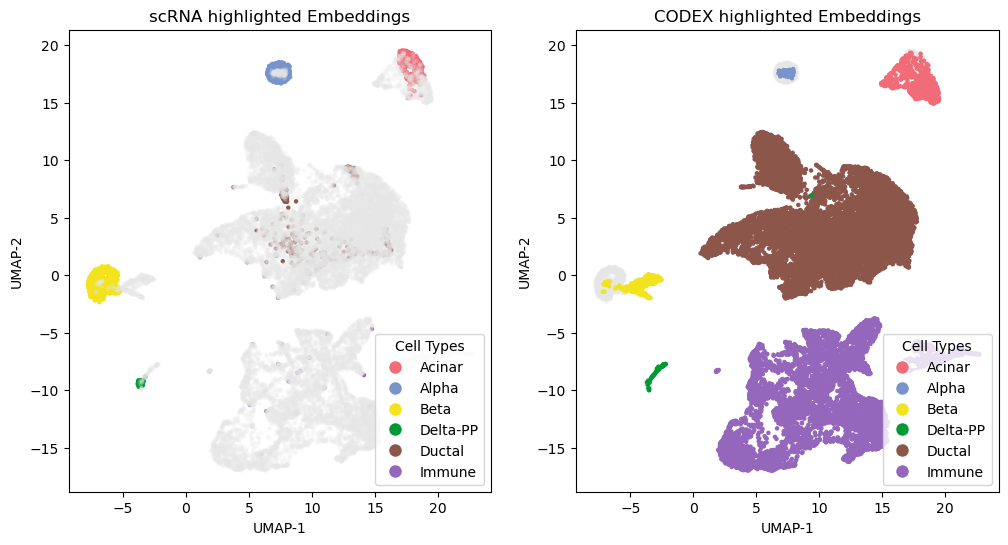

In [10]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
datatype = ['scRNA', 'CODEX']
ct_array_double = ct_array_double_2
datatype_array_double = np.concatenate([np.repeat(datatype[0], sum(matched_rna)), np.repeat(datatype[1], sum(matched_protein))], axis = 0)
ct_array1 = combined_adata[matched_rna,].obs['cell_type'].values
ct_array2 = protein_adata_filter[matched_protein].obs['cell_type'].values 

color_palette = plt.cm.tab10(np.linspace(0, 1, 10))[::-1]
cts = np.unique(ct_array_double)
num_type = len(cts)
if num_type > 10:
    repeats = -(-num_type // 10)
    color_palettes = np.tile(color_palette, (repeats, 1))
    colors = color_palettes[:num_type]
else:
    colors = color_palette[:num_type]
colorbar = {t: colors[i] for i, t in enumerate(cts)}

manual_colors = ['#F26B78', '#7995CC', '#F4E41E']
for i, color in enumerate(manual_colors):
    if i < len(cts):
        colorbar[cts[i]] = np.array([int(color.strip('#')[j:j+2], 16) / 256 for j in (0, 2, 4)] + [1])  # Convert hex to RGB tuple

if len(cts) >= 4:
    colorbar[cts[3]] = (0, 0.6, 0.2, 1.0)
    
color_points = np.array([colorbar[i] for i in ct_array_double])

dts = np.unique(datatype_array_double)
color_datatype = ["#FFA500", "#004D99"]
colorbardt = {t: color_datatype[i] for i, t in enumerate(dts)}
color_dt = np.array([colorbardt[i] for i in datatype_array_double])

grey = np.array([0.9, 0.9, 0.9, 0.2])[np.newaxis, :]

protein_id = np.array(range(0, len(ct_array1)))
rna_id = np.array(range(len(ct_array1), len(ct_array_double)))
color_points1 = color_points.copy()
color_points1[rna_id, :] = grey
color_points2 = color_points.copy()
color_points2[protein_id, :] = grey

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points1, s=5.)
axs[1].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points2, s=5.)
axs[0].set_title('scRNA highlighted Embeddings')
axs[1].set_title('CODEX highlighted Embeddings')
axs[0].set_xlabel('UMAP-1')
axs[0].set_ylabel('UMAP-2')
axs[1].set_xlabel('UMAP-1')
axs[1].set_ylabel('UMAP-2')
for i in axs:
    i.set_facecolor('none')
fig.patch.set_facecolor('none')

legend_celltype = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                              markerfacecolor=c, markersize=10) for t, c in colorbar.items()]
legend_dt = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                            markerfacecolor=c, markersize=10) for t, c in colorbardt.items()]

axs[0].legend(handles = legend_celltype, title = "Cell Types", loc = "lower right")
#plt.gca().add_artist(legend1)
axs[1].legend(handles = legend_celltype, title = "Cell Types", loc = "lower right")


plt.show()
